# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 100

start = datetime.datetime(2013, 1, 1)
end = datetime.date.today()

optimizer = 'RMSprop'

# 1. Download data and normalize it
Data since 1950 to today

In [3]:
def get_stock_data(stock_name, normalize=True):
    
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:
#         yesterday_value = pd.concat([df[:1], df[:len(df)-1]], ignore_index=True)
#         df = pd.concat([df[:]], ignore_index=True)
#         df = df / yesterday_value
        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

In [4]:
df = get_stock_data(stock_name, normalize=True)

# 2. Plot out the Normalized Adjusted close price

In [5]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low  Adj Close
Date                                               
2012-12-31  0.000000  0.000000  0.000000   0.000000
2013-01-02  0.018415  0.028142  0.021804   0.028664
2013-01-03  0.046494  0.030539  0.044587   0.026251
2013-01-04  0.044130  0.032486  0.047274   0.031868
2013-01-07  0.049633  0.031327  0.045434   0.028244


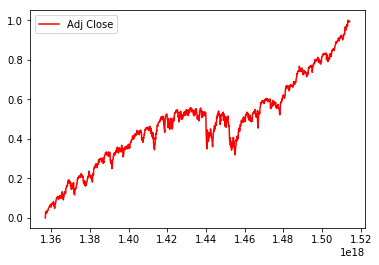

In [6]:
plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [8]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [9]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1112, 22, 4)

In [10]:
y_train.shape[0]

1112

# 4. Buidling neural network

In [11]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer=optimizer , metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [ ]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 1000 samples, validate on 112 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1832 - acc: 0.0000e+00 - val_loss: 0.3532 - val_acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 1s 685us/step - loss: 0.0619 - acc: 0.0000e+00 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 1s 719us/step - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 4/100
1000/1000 [==============================] - 1s 719us/step - loss: 0.0696 - acc: 0.0000e+00 - val_loss: 0.0633 - val_acc: 0.0000e+00
Epoch 5/100
1000/1000 [==============================] - 1s 734us/step - loss: 0.0059 - acc: 0.0000e+00 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 6/100
1000/1000 [==============================] - 1s 698us/step - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 7/100
1000/1000 [==============================] - 1s 707us/step - loss: 0.0037

# 7. Result on training set and testing set

In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [ ]:
model_score(model, X_train, y_train, X_test, y_test)

# 8. Prediction vs Real results

In [ ]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [ ]:
p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [ ]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [ ]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')

    figname = optimizer + stock_name + '_epochs' + str(epochs) + '_' + start.strftime("%Y%m%d") + '-' + end.strftime("%Y%m%d") + '.png'
    plt2.savefig(figname, format='png', bbox_inches='tight', transparent=True)
    plt2.show()

In [ ]:
plot_result(stock_name, p, y_test)

# 10. Save for consistency

In [ ]:
# model.save('LSTM_Stock_prediction-20170429.h5')